In [1]:
import pandas as pd
import numpy as np
from scipy import signal
from scipy.fftpack import fft, ifft, fftfreq
import stumpy
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import glob

### Read data
- some files need to use sep='\s+' to read and transpose

In [13]:
data_path = "../data-sets/KDD-Cup/data/*"
path_list = glob.glob(data_path)
file_names = {p.split("data/")[1].split("_")[0] : p  for p in path_list}

In [14]:
def read_data(file_id):
    
    file_path = file_names[file_id]
    
    if file_id in ["204","205", "206", "207", "208", "225","226", "242", "243"]:
        data = pd.read_csv(file_path, sep="\s+", header=None, names=["orig"])
        data = data.T
    else:
        data = pd.read_csv(file_path, sep=",", header=None, names=["orig"])

    point = int(file_path.split("_")[-1].split(".txt")[0])
    train = data.iloc[:point].reset_index(drop=True)
    test  = data.iloc[point:].reset_index(drop=True)
    
    return data, train, test, point

In [15]:
file_id = "007"
data, train, test, point = read_data(file_id)

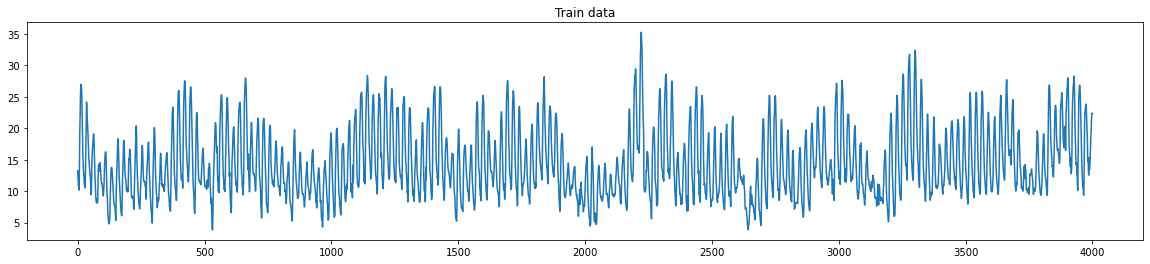

In [5]:
fig, ax = plt.subplots()
train["orig"].plot(legend=False, ax=ax, figsize=(20,4))
plt.title("Train data")
plt.show()

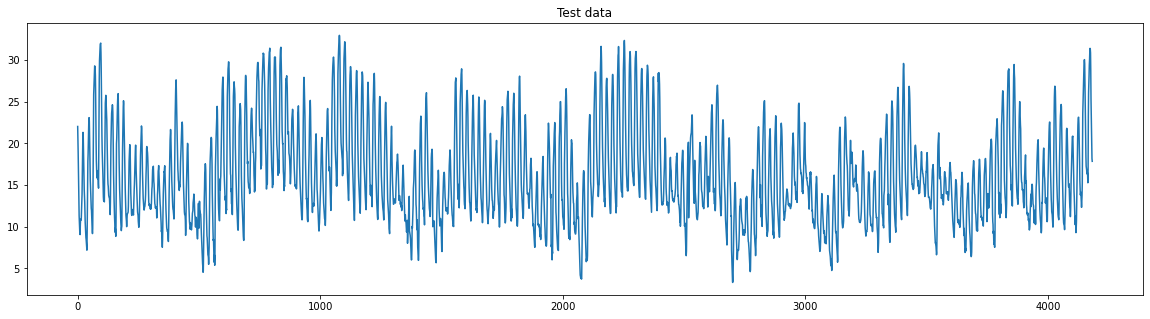

In [6]:
fig, ax = plt.subplots()
test["orig"].plot(legend=False, ax=ax, figsize=(20,5))
plt.title("Test data")
plt.show()

### Auto period finder
- find the window size for each time series

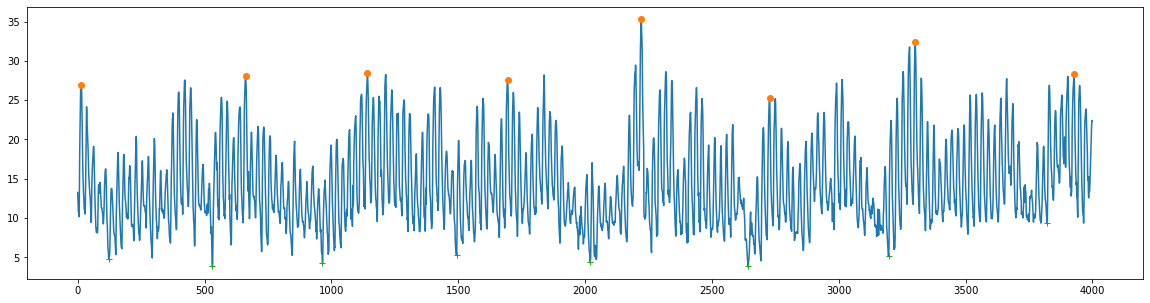

In [7]:
plt.figure(figsize=(20,5))
plt.plot(np.arange(len(train)),train)

a = signal.find_peaks(train.values.reshape(-1), distance=400)[0]
plt.plot(a, train.iloc[a],'o')

b = signal.find_peaks(-1*train.values.reshape(-1), distance=400)[0]
plt.plot(b, train.iloc[b],'+')
plt.show()

In [8]:
def find_period(arr, candidate_d):
    """
    @param arr: time series
    @param candidate_d: range to search for d
    """
    scores = []
    
    for d in candidate_d:
        peaks = signal.find_peaks(arr.reshape(-1), distance=d)[0] 
        valleys = signal.find_peaks(-arr.reshape(-1), distance=d)[0] 
        # calculate interval lengths pd and vd from peaks and valleys
        pd = np.mean(np.diff(peaks))
        vd = np.mean(np.diff(valleys))
        s_d = min(pd, vd) / np.sqrt(d)
        scores.append([d, s_d])
    
    # find argmin scores
    idx = np.argmin(np.array(scores)[:,1])
    return scores[idx][0]

In [9]:
# increase the window size from 40 to 767, at a rate of 10%

min_window_size = 40
max_window_size = 800
growth_rate = 1.1

# number of different window size
size = int(np.log(max_window_size / min_window_size) / np.log(growth_rate)) + 1
rates = np.full(size, growth_rate) ** np.arange(size)

candidate_d = list(map(int, min_window_size * rates))

In [10]:
# for file_id in file_ids[205:]:
file_id = "007"
data, train, test, point = read_data(file_id)

print("file id: %s" % file_id)
print(find_period(train.values, candidate_d))

w = find_period(train.values, candidate_d)

file id: 007
44


### Fourier Transformation
- low-pass filter: remove noise
    - need to find the frequency threshold 
- high-pass filter: extract noise
    - need to find the frequency threshold
- smoothing: remove noise or twisted frequency signals (not significant and hard to tune)

In [11]:
fft_orig = fft(data["orig"].values) 

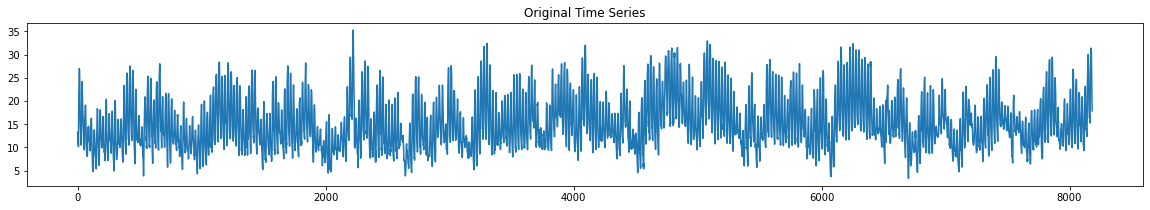

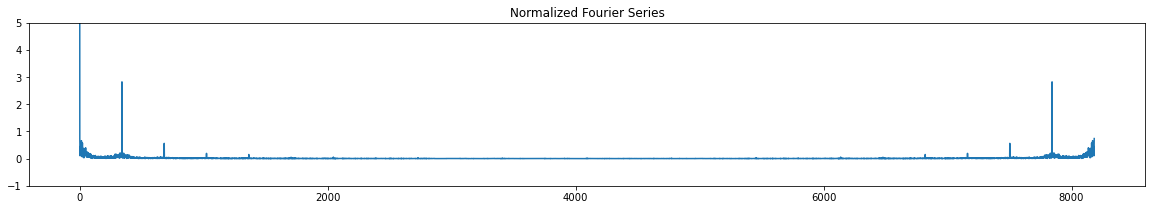

In [12]:
plt.figure(figsize=(20,3))
plt.plot(np.arange(data.size), data["orig"])
plt.title("Original Time Series")
plt.show()

plt.figure(figsize=(20,3))
plt.plot(np.arange(data.size), np.abs(fft_orig / len(data)))
plt.title("Normalized Fourier Series")
plt.ylim(-1, 5)
plt.show()

- how to choose the filter threshold, depending on the time step to sample frequency

In [13]:
def get_peak_frequency(df, list_w):
    peak = []
    for w in list_w:
        time_step = 1 / w
        fft_y = fft(df["orig"].values) 
        sample_freq = fftfreq(df.size, d=time_step)
        pos_mask = np.where(sample_freq > 0)
        freqs = sample_freq[pos_mask]
        power = np.abs(fft_y)**2
        peak_freq = freqs[power[pos_mask].argmax()]
        peak.append(peak_freq)
    return peak

- Apply low-pass filter to remove noise, transform back to time domain and compute the residuals
    - set the frequency larger than peak frequency to 0, only preserve the low frequency

In [17]:
peak_list = get_peak_frequency(data, [w])
peak_list

peak_freq = peak_list[0]

In [18]:
peak_freq

1.8333333333333335

/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


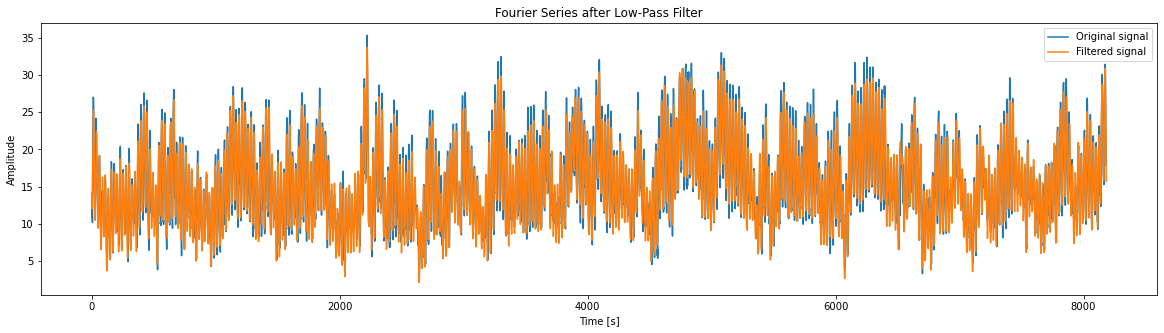

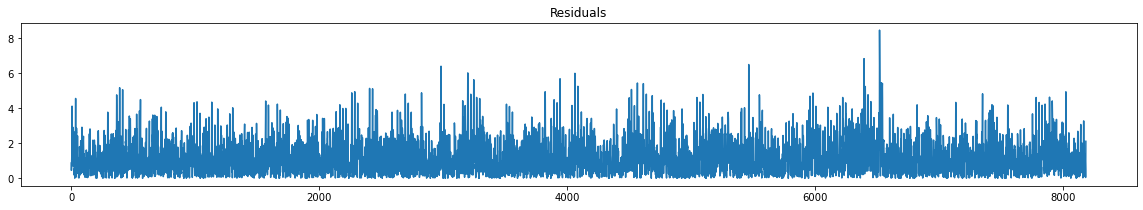

In [19]:
# peak_freq = 5
sample_freq = fftfreq(data.size, d=1 /w)

low_freq_fft = fft_orig.copy()
low_freq_fft[np.abs(sample_freq) > peak_freq] = 0
low_fft = ifft(low_freq_fft)

plt.figure(figsize=(20, 5))
plt.plot(np.arange(data.size), data["orig"], label='Original signal')
plt.plot(np.arange(data.size), low_fft, linewidth=1.5, label='Filtered signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title("Fourier Series after Low-Pass Filter")
plt.legend(loc='best')

plt.figure(figsize=(20,3))
plt.plot(np.arange(data.size), np.abs(data["orig"] - low_fft))
plt.title("Residuals")
plt.show()

- Apply high-pass filter to extract noise

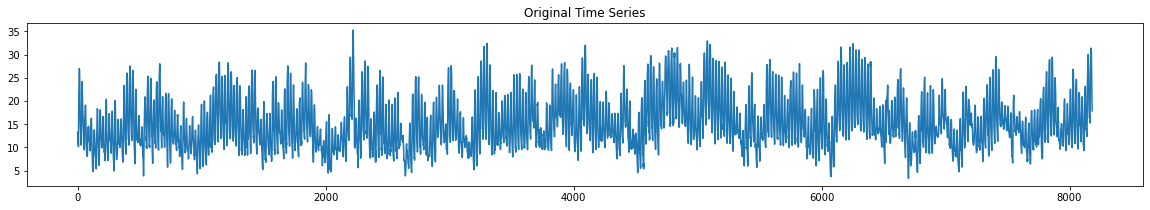

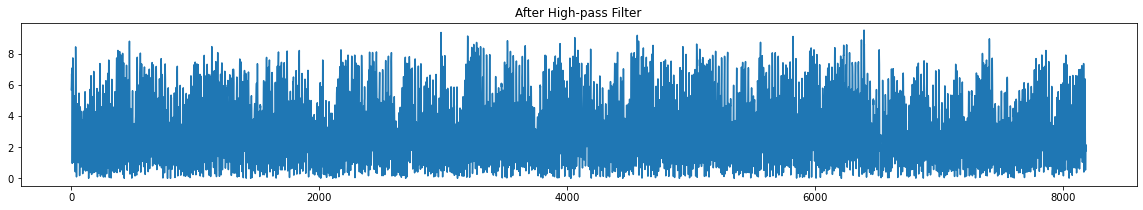

In [20]:
high_freq_fft = fft_orig.copy()
high_freq_fft[np.abs(sample_freq) < peak_freq] = 0
high_fft = ifft(high_freq_fft)

plt.figure(figsize=(20,3))
plt.plot(np.arange(data.size), data["orig"])
plt.title("Original Time Series")

plt.figure(figsize=(20,3))
plt.plot(np.arange(data.size), np.abs(high_fft))
plt.title("After High-pass Filter")
plt.show()

In [88]:
def fourier_transform(arr, ws):
    fft_orig = fft(arr["orig"].values) 

    # sample frequency in d time step
    sample_freq = fftfreq(len(arr), d = 1 / ws)
    pos_mask = np.where(sample_freq > 0)
    freqs = sample_freq[pos_mask]
    power = np.abs(fft_orig)**2
    peak_freq = freqs[power[pos_mask].argmax()]

    # apply low-pass filter
    low_freq_fft = fft_orig.copy()
    low_freq_fft[np.abs(sample_freq) > peak_freq] = 0
    low_fft = ifft(low_freq_fft)
    # compute the residual
    low_fft_res = np.abs(arr["orig"] - low_fft)

    # apply high-pass filter
    high_freq_fft = fft_orig.copy()
    high_freq_fft[np.abs(sample_freq) < peak_freq] = 0
    high_fft = pd.Series(np.abs(ifft(high_freq_fft)))
    
    return low_fft_res, high_fft

In [98]:
fft_dict = {}

for w in candidate_d:
    low_fft, high_fft = fourier_transform(data, w)
    data["low_fft_score"]  = smoothing(low_fft.values, w, padding_len=3)
    conf, idx, peak = compute_confidence_score(data, "low_fft", w, point)
    fft_dict["%d, low_fft" % w] = {"confidence": conf, "idx": idx, "peak": peak}   
    
    data["high_fft_score"] = smoothing(high_fft.values, w, padding_len=3)
    conf, idx, peak = compute_confidence_score(data, "high_fft", w, point)
    fft_dict["%d, high_fft" % w] = {"confidence": conf, "idx": idx, "peak": peak}   

The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set


In [99]:
fft_df = pd.DataFrame.from_dict(fft_dict, orient="index")
fft_df.sort_values(["confidence"], ascending=False)

,confidence,idx,peak
"325, low_fft",1.310766,6544.0,1.995875
"358, low_fft",1.298953,6554.0,1.947875
"151, low_fft",1.274095,6543.0,2.269916
"85, low_fft",1.268032,6453.0,2.403407
"167, low_fft",1.264331,6544.0,2.239753
...,...,...,...
"476, high_fft",1.005277,5249.0,4.294678
"64, high_fft",1.000640,4120.0,5.281207
"634, low_fft",NaN,NaN,NaN
"697, low_fft",NaN,NaN,NaN


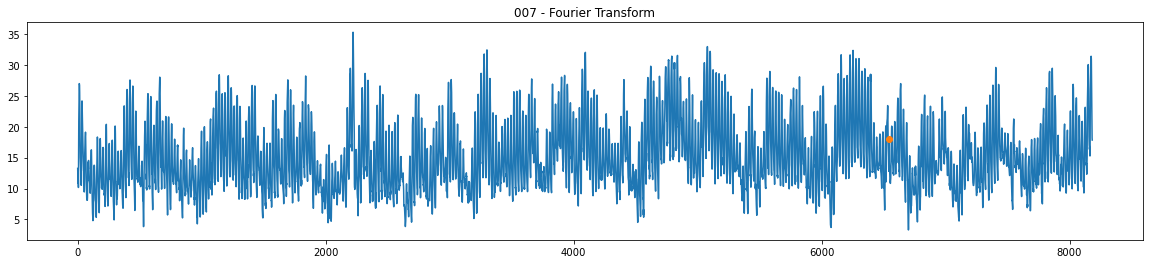

In [102]:
plot_anomaly(data, fft_df, name = "Fourier Transform")

- smooth the fft_orig in frequency domain, transform back to time domain and compute the residuals
    - not significant, hard to find a systematic way to smooth the series in frequency domain

In [ ]:
smooth_freq_fft = fft_orig.copy()
smooth_freq = np.convolve(smooth_freq_fft, np.ones(w) / w,mode='same')
smooth_freq = np.convolve(smooth_freq, np.ones(w) / w,mode='same')

/Library/anaconda3/envs/data_mining/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


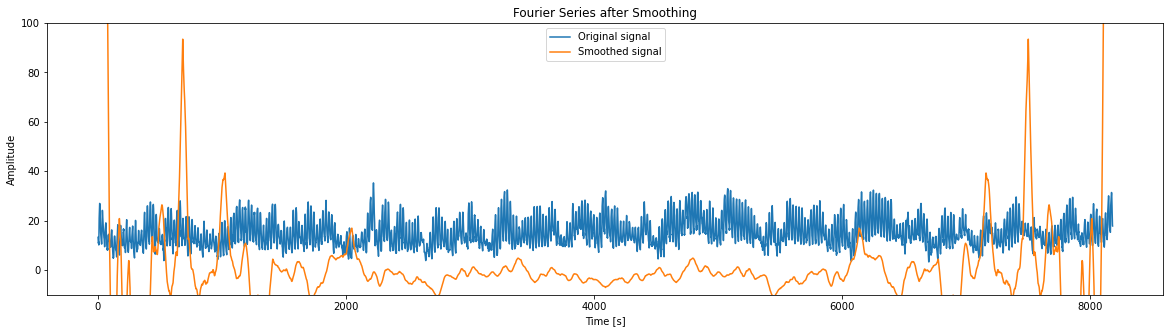

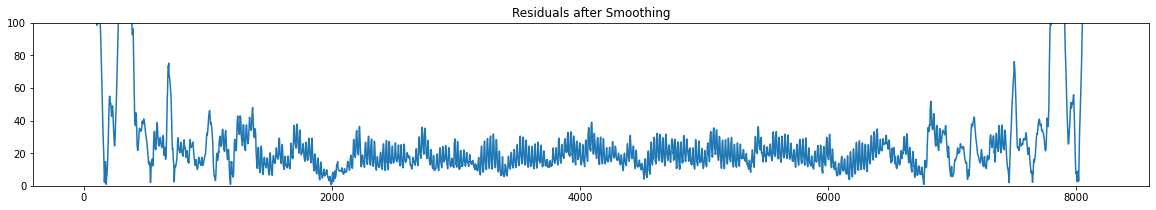

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(np.arange(data.size), data["orig"], label='Original signal')
plt.plot(np.arange(data.size), smooth_freq, linewidth=1.5, label='Smoothed signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title("Fourier Series after Smoothing")
plt.ylim((-10, 100))
plt.legend(loc='best')

plt.figure(figsize=(20,3))
plt.plot(np.arange(data.size), np.abs(data["orig"] - smooth_freq))
plt.ylim(0, 100)
plt.title("Residuals after Smoothing")
plt.show()

### Score function

In [137]:
def smoothing(arr, w, padding_len=3):
    """
    @param arr: a pandas series
    @param w: window size
    @param padding_len: default to be 3
    return the smoothing scores
    """
    padding = w * padding_len
    arr = pd.DataFrame(arr, columns=["metric"])

    arr['mask'] = 0.0
    arr.loc[arr.index[w:-w-padding], 'mask'] = 1.0
    arr['mask'] = arr['mask'].rolling(padding, min_periods=1).sum() / padding
    arr["score"] = arr["metric"].rolling(window=w).mean() * arr['mask']
        
    return arr["score"]

def compute_confidence_score(s, w, split_point):
    """
    @param s: score dataframe
    @param name: name of the score 
    @param w: window _size
    @param split_point: index splitting train and test time series
    return the ratio of first peak and second peak
    """
    y = s
#     y = s["%s_score" % name].copy()
    
    # find local maximum
    local_max = (y == y.rolling(window=w).max())
    y.loc[~local_max] = np.nan
    idx_1 = y.idxmax()
    peak_1 = y.max()
    
    # no local maximum
    if not np.isfinite(peak_1):
        print("The value of the first peak is infinite")
        return None, None, None
    else:
        # the maximum is not in test set
        begin = idx_1 - w
        end = idx_1 + w
        if begin < split_point:
            print("The first peak does not locate in the test set")
            return None, None, None
        else:
            # find peak_2 except for this interval [peak_1 - w, peak_1 + w)
            y.iloc[begin:end] = np.nan
            
            idx_2 = y.idxmax()
            peak_2 = y.max()
            
            # if the second height is 0, skip
            if peak_2 == 0. or np.isnan(peak_2):
                print("The second peak's height is 0 or nan")
                return None, None, None
            else:
                ratio = peak_1 / peak_2
                
    return ratio, idx_1, peak_1

In [104]:
def plot_anomaly(data, df, name):
    plt.figure(figsize=(20,4))
    plt.plot(np.arange(len(data)), data["orig"])

    a = np.array(df[df["confidence"] == df["confidence"].max()]["idx"])
    a.sort()
    plt.plot(a, data.loc[a, "orig"],'o')
    plt.title("%s - %s" % (file_id, name))

    plt.savefig("./picture/%s_%s.jpg" % (file_id, name))
    plt.show()

#### peak-to-peak value
- orig: original time series
- diff: first-order diff
- acc: second-order diff
- compute ori_p2p, diff_p2p, acc_p2p
- orig_p2p_inv: inverse of original time series

#### Percentage of time when the absolute value of 1st order diff is small
- diff_small

In [144]:
for w in candidate_d:
    conf, idx, peak = inverse(data, "diff", w, point)
    print(conf, idx, peak)

1.1017715799910166 6518 12.738652312499882
1.0817390114983254 6518 12.85669801136351
1.075448567255761 6518 12.955069427083492
1.076187399017889 6518 13.057152971698246
1.0718054582496102 6518 13.141635905172539
1.0596204947697996 6518 13.22559082031268
1.049845429656802 6518 13.295153464285786
1.0412960457959088 6518 13.362608149350748
1.0306959334182524 6518 13.426094911764617
1.0194056076723126 6518 13.484600664893579
1.0157607278344676 6518 13.532882111650537
1.0139717908665555 6518 13.583275548245886
1.0130416421486306 6518 13.631922340000129
1.0260499641133014 6518 13.867391935507476
1.039041628058302 6518 14.093631655629295
1.0383322332691134 6518 14.135490724550865
1.0349518835224958 6518 14.160160300546362
1.0294595965892122 6518 14.184379534653536
1.0247558616430132 6518 14.205394801801775
1.020405206781194 6518 14.22291075409802
1.0158312177117823 6518 14.231815330855163
1.011798251428107 6518 14.239742810811018
1.0118453135110805 6518 14.297685747692782
1.0135573475928359 6

In [145]:
def peak_to_peak_value(arr: pd.DataFrame, name: str, ws: int, split_point: int) -> pd.DataFrame:
    """
    calculate the difference of rolling max and min in each window
    @param arr: dataframe of time series
    @param name: name of the time series
    @param ws: window size
    @param split_point: point to split the train and test set
    """
    slide_max = arr[name].rolling(window=ws).max()
    slide_min = arr[name].rolling(window=ws).min()
    score = (slide_max - slide_min).shift(-ws)
    smooth_score = smoothing(score.values, ws)
    conf, idx, peak = compute_confidence_score(smooth_score, ws, split_point)
    return conf, idx, peak
    

def inverse(arr: pd.DataFrame, name: str, ws: int, split_point: int,threshold = 0.1) -> pd.DataFrame:
    """
    clip any values below mean * threshold
    @param arr: dataframe of time series
    @param name: name of the tim series
    @param w: window size
    @param threshold: clip the lower bound of the series
    """
    numerator = arr[name].mean()
    denominator = arr[name].clip(lower = numerator * threshold)
    score = numerator / denominator
    smooth_score = smoothing(score.values, ws)
    conf, idx, peak = compute_confidence_score(smooth_score, ws, split_point)
    return conf, idx, peak

def get_small_diff(arr, name, w, threshold=0.1):
    """
    region where the absolute value of the first order derivative is very small, less than the threshold quantile
    @param arr: time series
    @param name: name of the time series
    @param w: window size
    @param threshold: threshold of quantile
    """
    arr_abs = arr[name].abs()
    cond = arr_abs <= arr_abs.quantile(threshold)
    arr[f'{name}_small'] = cond.rolling(w).mean().shift(-w)
    arr[f'{name}_small_score'] = smoothing(arr[f'{name}_small'].values, w)
    return arr

In [106]:
data["diff"] = data["orig"].diff(1)
data["acc"] = data["diff"].diff(1)

In [107]:
p2p = {}

for w in candidate_d:
    data = peak_to_peak_value(data, "orig", w)
    conf, idx, peak = compute_confidence_score(data, "orig_p2p", w, point)
    p2p["%d, orig_p2p" % w] = {"confidence": conf, "idx": idx, "peak": peak}    
    
    data = peak_to_peak_value(data, "diff", w)
    conf, idx, peak = compute_confidence_score(data, "diff_p2p", w, point)
    p2p["%d, diff_p2p" % w] = {"confidence": conf, "idx": idx, "peak": peak}    
    
    data = peak_to_peak_value(data, "acc", w)
    conf, idx, peak = compute_confidence_score(data, "diff_p2p", w, point)
    p2p["%d, acc_p2p" % w] = {"confidence": conf, "idx": idx, "peak": peak}    
    
    data = inverse(data, "orig_p2p", w)
    conf, idx, peak = compute_confidence_score(data, "orig_p2p_inv", w, point)
    p2p["%d, orig_p2p_inv" % w] = {"confidence": conf, "idx": idx, "peak": peak}   
    
    data = get_small_diff(data, "diff", w)
    conf, idx, peak = compute_confidence_score(data, "diff_small", w, point)
    p2p["%d, diff_small" % w] = {"confidence": conf, "idx": idx, "peak": peak}
    
p2p_df = pd.DataFrame.from_dict(p2p, orient="index")
p2p_df.sort_values(["confidence"], ascending=False)

The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first pea

,confidence,idx,peak
"151, diff_small",1.120031,7517.0,0.187843
"138, diff_small",1.116209,7517.0,0.194182
"53, orig_p2p_inv",1.111336,7483.0,2.328101
"167, diff_small",1.108628,7515.0,0.179677
"40, diff_p2p",1.101772,6518.0,12.738652
...,...,...,...
"697, orig_p2p_inv",NaN,NaN,NaN
"697, diff_small",NaN,NaN,NaN
"767, orig_p2p",NaN,NaN,NaN
"767, orig_p2p_inv",NaN,NaN,NaN


In [109]:
p2p_df[~p2p_df["confidence"].isna()]

,confidence,idx,peak
"40, diff_p2p",1.101772,6518.0,12.738652
"40, acc_p2p",1.101772,6518.0,12.738652
"44, diff_p2p",1.081739,6518.0,12.856698
"44, acc_p2p",1.081739,6518.0,12.856698
"44, orig_p2p_inv",1.048069,7476.0,2.481593
...,...,...,...
"634, acc_p2p",1.020409,5647.0,13.078796
"697, diff_p2p",1.083391,5463.0,12.504720
"697, acc_p2p",1.083391,5463.0,12.504720
"767, diff_p2p",1.089626,5115.0,11.454816


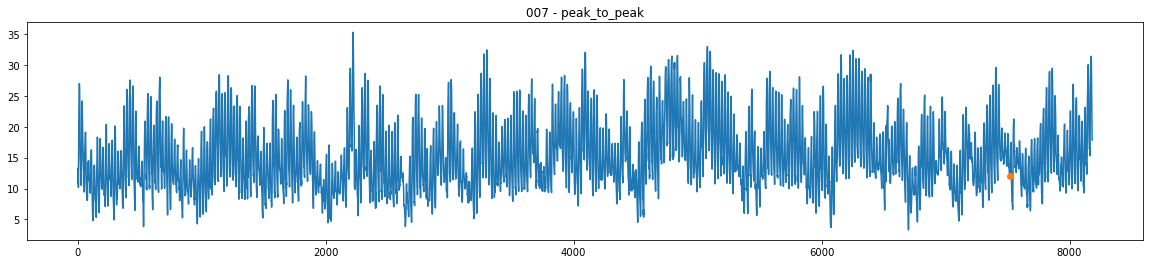

In [110]:
plot_anomaly(data, p2p_df, "peak_to_peak")

#### sd of acc (2nd order diff) and inverse of sd of acc
- acc_std: 
- acc_std_inv:

In [111]:
def get_std(arr, name, w):
    """
    standard deviation
    @param arr: time series
    @param name: name of the time series
    @param w: window size
    """
    arr[f'{name}_std'] = arr[name].rolling(window=w).std().shift(-w)
    arr[f'{name}_std_score'] = smoothing(arr[f'{name}_std'].values, w)
    return arr


def std_inv(arr, name, w):
    """
    inverse of standard deviation of 2nd order differential
    @param arr: time series
    @param name: name of time series
    @param w: window size
    """
    arr = inverse(arr, name, w)
    return arr

In [113]:
std_dict = {}

for w in candidate_d:
    data = get_std(data, "acc", w)
    conf, idx, peak = compute_confidence_score(data, "acc_std", w, point)
    std_dict["%d, acc_std" % w] = {"confidence": conf, "idx": idx, "peak": peak}    
    
    data = std_inv(data, "acc_std", w)
    conf, idx, peak = compute_confidence_score(data, "acc_std_inv", w, point)
    std_dict["%d, acc_std_inv" % w] = {"confidence": conf, "idx": idx, "peak": peak} 
    
std_df = pd.DataFrame.from_dict(std_dict, orient="index")
std_df[~std_df["confidence"].isna()].sort_values(["confidence"], ascending=False)

The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set


,confidence,idx,peak
"40, acc_std",1.383029,6519.0,2.558676
"44, acc_std",1.367817,6519.0,2.465225
"48, acc_std",1.332442,6519.0,2.382499
"53, acc_std",1.291590,6519.0,2.292172
"58, acc_std",1.263197,6519.0,2.211801
"64, acc_std",1.237260,6519.0,2.125524
"70, acc_std",1.214925,6519.0,2.049023
"77, acc_std",1.194779,6519.0,1.970687
"85, acc_std",1.175576,6519.0,1.894952
"94, acc_std",1.156248,6519.0,1.821066


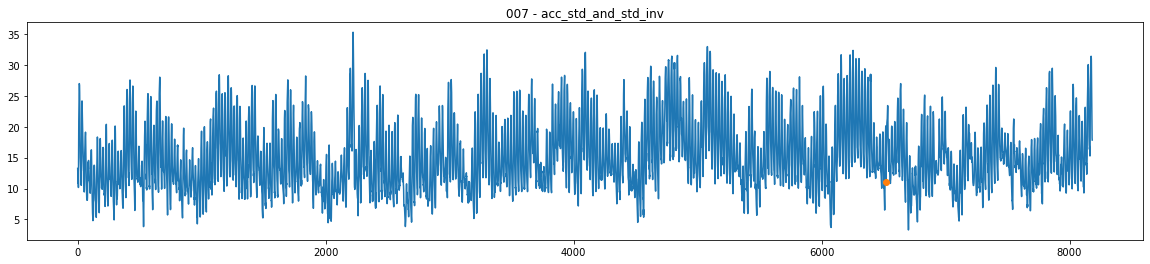

In [114]:
plot_anomaly(data, std_df, name = "acc_std_and_std_inv")

#### Matrix Profile of origin
- self-join
    - what if the discord index locates within the training data part? How to ensure that the discord index locates in the test dataset
    - reference https://stumpy.readthedocs.io/en/latest/Tutorial_STUMPY_Basics.html
- AB-join
    - reference: https://stumpy.readthedocs.io/en/latest/Tutorial_AB_Joins.html

In [115]:
def orig_mp_outlier(arr, name, w):
    """
    use self-join version of matrix profile
    @param arr: time series, train + test
    @param name: name of time series
    @param w: window size
    """
    # (distance, neighbor_idx, , )
    mp = stumpy.stump(arr["orig"], w)
    arr[f'{name}_score'] = smoothing(mp[:, 0], w)
    return arr

def orig_mp_novelty(train, test, arr, name, w, point):
    """
    for every subsequence in test, find its furthest subsequence in train
    @param train: train time series
    @param test: test time series
    @param arr: full time series
    @param name: name of time series
    @param w: window size
    @param point: split point to separate train and test set
    """
    ab_mp = stumpy.stump(T_A = test["orig"], m = w, T_B = train["orig"], ignore_trivial = False)
    begin = point
    end = begin + len(ab_mp) - 1
    arr.loc[begin:end, f'{name}_score'] = ab_mp[:,0]
    arr[f'{name}_score'] = smoothing(arr[f'{name}_score'].values, w)
    return arr

In [116]:
mp_dict = {}

for w in candidate_d:
    data = orig_mp_outlier(data, "orig_mp_outlier", w)
    conf, idx, peak = compute_confidence_score(data, "orig_mp_outlier", w, point)
    mp_dict["%d, orig_mp_outlier" % w] = {"confidence": conf, "idx": idx, "peak": peak}    

    data = orig_mp_novelty(train, test, data, "orig_mp_novelty", w, point)
    conf, idx, peak = compute_confidence_score(data, "orig_mp_novelty", w, point)
    mp_dict["%d, orig_mp_novelty" % w] = {"confidence": conf, "idx": idx, "peak": peak}    

mp_df = pd.DataFrame.from_dict(mp_dict, orient="index")
mp_df[~mp_df["confidence"].isna()].sort_values(["confidence"], ascending=False)

The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The first peak does not locate in the test set
The second peak's height is 0 or nan
The first peak does not locate in the test set
The second peak's height is 0 or nan
The first peak does not locate in the test set
The second peak's height is 0 or nan
The first peak does not locate in the test set
The value of the first peak is infinite
The first peak does not locate in the test set
The value of the first peak is infinite


,confidence,idx,peak
"70, orig_mp_novelty",1.796807,6527.0,7.352354
"64, orig_mp_novelty",1.793689,6527.0,7.034474
"77, orig_mp_novelty",1.784134,6528.0,7.653421
"85, orig_mp_novelty",1.780486,6527.0,8.008941
"94, orig_mp_novelty",1.746479,6526.0,8.314554
"85, orig_mp_outlier",1.745070,6528.0,7.664546
"58, orig_mp_novelty",1.742572,6525.0,6.557603
"94, orig_mp_outlier",1.706158,6527.0,8.050386
"53, orig_mp_novelty",1.691684,6525.0,6.078453
"103, orig_mp_novelty",1.685264,6526.0,8.593567


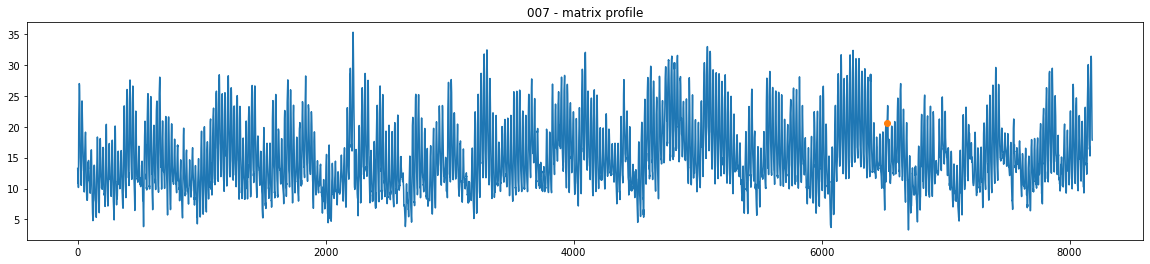

In [117]:
plot_anomaly(data, mp_df, name = "matrix profile")

In [7]:
result_df = pd.read_csv("../results/007.csv")

In [8]:
result_df.head()

,Unnamed: 0,confidence,idx,peak
0,"ws=70, orig_mp_novelty",1.796807,6527.0,7.352354
1,"ws=64, orig_mp_novelty",1.793689,6527.0,7.034474
2,"ws=77, orig_mp_novelty",1.784134,6528.0,7.653421
3,"ws=85, orig_mp_novelty",1.780486,6527.0,8.008941
4,"ws=94, orig_mp_novelty",1.746479,6526.0,8.314554


Text(0.5, 1.0, '007 - Anomaly Point')

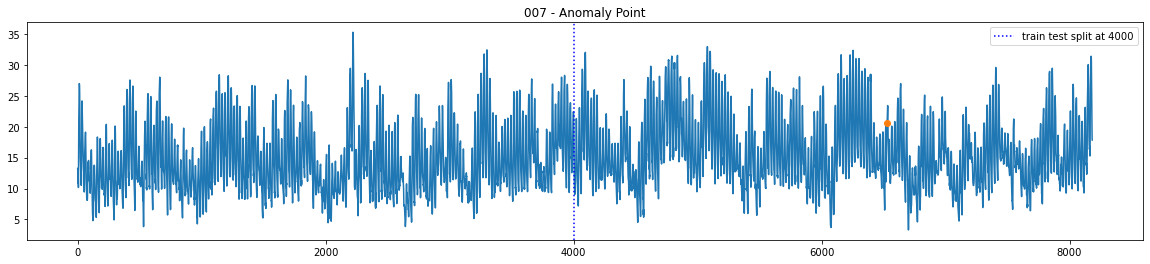

In [23]:
plt.figure(figsize=(20,4))
plt.plot(np.arange(len(data)), data["orig"])

a = np.array(result_df[result_df["confidence"] == result_df["confidence"].max()]["idx"])
a.sort()
plt.axvline(x=point, ls=":", label="train test split at %d" % point, c = "b")
plt.legend()
plt.plot(a, data.loc[a, "orig"],'o')
plt.title("%s - Anomaly Point" % (file_id))